# MCMC: comparison of various algorithms

This script illustrates performance of various MCMC algorithms currently integrated in UQpy:
- Metropolis Hastings (MH)
- Modified Metropolis Hastings (MMH)
- Affine Invariant with Stretch moves (Stretch)
- Adaptive Metropolis with delayed rejection (DRAM)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

from UQpy.sampling import MetropolisHastings, Stretch, ModifiedMetropolisHastings, DREAM, DRAM
from UQpy.sampling.input_data import MhInput, StretchInput, MmhInput, DreamInput, DramInput

## Affine invariant with Stretch moves

This algorithm requires as seed a few samples near the region of interest. Here MH is first run to obtain few samples, used as seed within the Stretch algorithm.

In [2]:
def log_Rosenbrock(x):
     return (-(100*(x[:, 1]-x[:, 0]**2)**2+(1-x[:, 0])**2)/20)

(5000, 2)


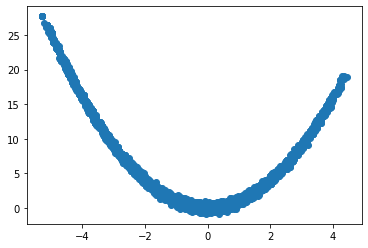

In [3]:
mh_input = MhInput()
mh_input.dimension=2
mh_input.burn_length=0
mh_input.jump=10
mh_input.chains_number=1
mh_input.log_pdf_target=log_Rosenbrock

x = MetropolisHastings(mh_input=mh_input, samples_number=5000)
print(x.samples.shape)
plt.plot(x.samples[:, 0], x.samples[:, 1], 'o')
plt.show()

(5000, 2)


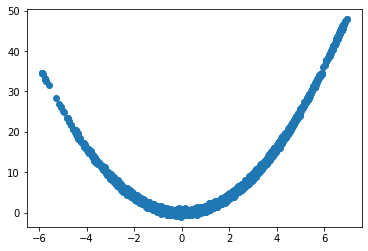

In [4]:
stretch_input = StretchInput()
stretch_input.burn_length=0
stretch_input.jump=10
stretch_input.log_pdf_target=log_Rosenbrock
stretch_input.seed=x.samples[:10]
stretch_input.scale=2.

x = Stretch(stretch_input=stretch_input, samples_number=5000)
print(x.samples.shape)
plt.plot(x.samples[:, 0], x.samples[:, 1], 'o')
plt.show()

## DREAM algorithm: compare with MH (inputs parameters are set as their default values)

In [5]:
# Define a function to sample seed uniformly distributed in the 2d space ([-20, 20], [-4, 4])
from UQpy.distributions import Uniform, JointIndependent
prior_sample = lambda nsamples: np.array([[-2, -2]]) + np.array([[4, 4]]) * JointIndependent(
    [Uniform(), Uniform()]).rvs(nsamples=nsamples)

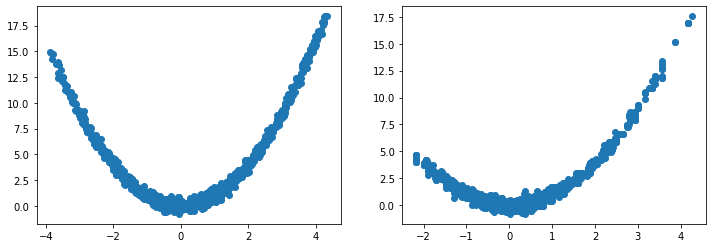

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
seed = prior_sample(nsamples=7)

mh_input = MhInput()
mh_input.dimension=2
mh_input.burn_length=500
mh_input.jump=50
mh_input.seed=seed
mh_input.log_pdf_target=log_Rosenbrock

x = MetropolisHastings(mh_input=mh_input, samples_number=1000)
ax[0].plot(x.samples[:, 0], x.samples[:, 1], 'o')

dream_input = DreamInput()
dream_input.dimension = 2
dream_input.burn_length = 500
dream_input.jump = 50
dream_input.seed = seed
dream_input.log_pdf_target = log_Rosenbrock

x = DREAM(dream_input=dream_input, samples_number=1000)
ax[1].plot(x.samples[:, 0], x.samples[:, 1], 'o')

plt.show()

## DRAM algorithm 

time to run MH: 1.6095149517059326s


/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/sampling/mcmc/DRAM.py:194: RuntimeWarning: overflow encountered in exp
  alpha_cand_cand2 = min(1.0, np.exp(log_p_candidate[nc] - log_p_cand2))


time to run DRAM: 8.186672687530518s


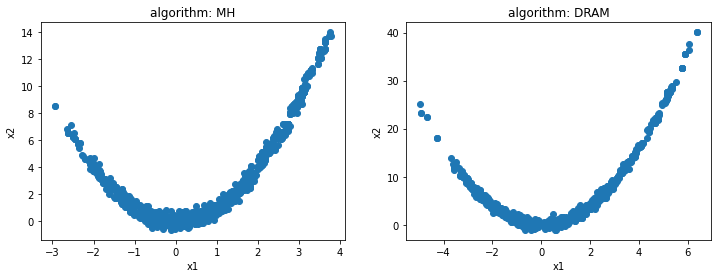

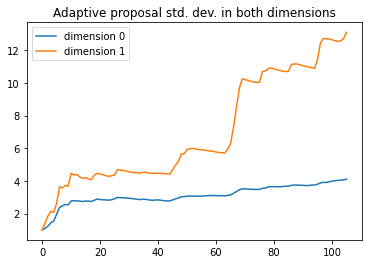

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
t = time.time()
seed = prior_sample(nsamples=1)

mh_input = MhInput()
mh_input.dimension = 2
mh_input.burn_length = 500
mh_input.jump = 10
mh_input.seed = seed
mh_input.log_pdf_target = log_Rosenbrock
x = MetropolisHastings(mh_input=mh_input, samples_number=1000)
ax[0].plot(x.samples[:, 0], x.samples[:, 1], 'o')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('algorithm: MH')
print('time to run MH' + ': {}s'.format(time.time() - t))

dram_input = DramInput()
dram_input.dimension=2
dram_input.burn_length=500
dram_input.jump=10
dram_input.seed=seed
dram_input.log_pdf_target=log_Rosenbrock
dram_input.save_covariance=True

x = DRAM(dram_input=dram_input, samples_number=1000)
ax[1].plot(x.samples[:, 0], x.samples[:, 1], 'o')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].set_title('algorithm: DRAM' )
print('time to run DRAM'  + ': {}s'.format(time.time() - t))

plt.show()

# look at the covariance adaptivity
fig, ax = plt.subplots()
adaptive_covariance = np.array(x.adaptive_covariance)
for i in range(2):
    ax.plot(np.sqrt(adaptive_covariance[:, 0, i, i]), label='dimension {}'.format(i))
ax.set_title('Adaptive proposal std. dev. in both dimensions')
ax.legend()
plt.show()

## MMH: target pdf is given as a joint pdf

The target pdf should be a 1 dimensional distribution or set of 1d distributions.

In [8]:
from UQpy.distributions import Normal
proposal = [Normal(), Normal()]
proposal_is_symmetric = [False, False]

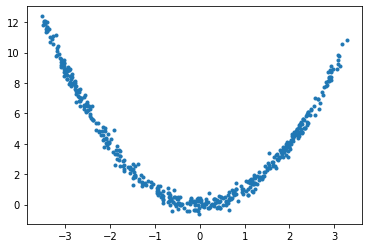

In [9]:
mmh_input = MmhInput()
mmh_input.dimension=2
mmh_input.burn_length=500
mmh_input.jump=50
mmh_input.log_pdf_target=log_Rosenbrock
mmh_input.proposal=proposal
mmh_input.proposal_is_symmetric=proposal_is_symmetric
mmh_input.chains_number=1

x = ModifiedMetropolisHastings(mmh_input=mmh_input, samples_number=500)

fig, ax = plt.subplots()
ax.plot(x.samples[:, 0], x.samples[:, 1], linestyle='none', marker='.')

## MMH: target pdf is given as a couple of independent marginals

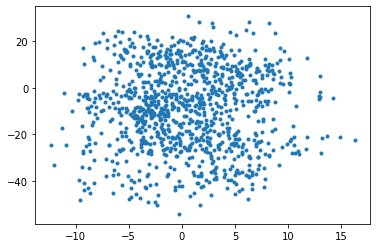

(1000, 2)


In [10]:
log_pdf_target = [Normal(loc=0., scale=5.).log_pdf, Normal(loc=0., scale=20.).log_pdf]

proposal = [Normal(), Normal()]
proposal_is_symmetric = [True, True]

mmh_input = MmhInput()
mmh_input.dimension = 2
mmh_input.burn_length = 100
mmh_input.jump = 10
mmh_input.log_pdf_target = log_pdf_target
mmh_input.proposal = proposal
mmh_input.proposal_is_symmetric = proposal_is_symmetric
mmh_input.chains_number = 1

x = ModifiedMetropolisHastings(mmh_input=mmh_input, samples_number=1000)

fig, ax = plt.subplots()
ax.plot(x.samples[:, 0], x.samples[:, 1], linestyle='none', marker='.')
plt.show()
print(x.samples.shape)

## Use random_state to provide repeated results

In [11]:
from UQpy.distributions import Normal, Gumbel, JointCopula, JointIndependent, Uniform
seed = Uniform().rvs(nsamples=2 * 10).reshape((10, 2))
dist_true = JointCopula(marginals=[Normal(), Normal()], copula=Gumbel(theta=2.))
proposal = JointIndependent(marginals=[Normal(scale=0.2), Normal(scale=0.2)])

mmh_input = MmhInput()
mmh_input.log_pdf_target=dist_true.log_pdf
mmh_input.proposal=proposal
mmh_input.seed=[0., 0.]
mmh_input.random_state=123

for _ in range(3):
    sampler = ModifiedMetropolisHastings(mmh_input=mmh_input, samples_number=500)
    print(sampler.samples.shape)
    print(np.round(sampler.samples[-5:], 4))

/Users/dimitris/PycharmProjects/dimtsap/UQpy/src/UQpy/distributions/copulas/Gumbel.py:65: RuntimeWarning: invalid value encountered in reciprocal
  * ((-log(u)) ** theta + (-log(v)) ** theta) ** (-2 + 2 / theta)


(500, 2)
[[1.5053 1.075 ]
 [1.207  1.1124]
 [1.4886 1.2361]
 [1.343  1.2324]
 [1.2618 0.8524]]
(500, 2)
[[1.5053 1.075 ]
 [1.207  1.1124]
 [1.4886 1.2361]
 [1.343  1.2324]
 [1.2618 0.8524]]
(500, 2)
[[1.5053 1.075 ]
 [1.207  1.1124]
 [1.4886 1.2361]
 [1.343  1.2324]
 [1.2618 0.8524]]


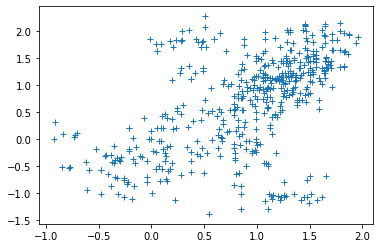

In [12]:
plt.plot(sampler.samples[:, 0], sampler.samples[:, 1], linestyle='none', marker='+')